# KTRLite Examples

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import matplotlib
import matplotlib.pyplot as plt

import orbit
from orbit.models import KTRLite

from orbit.utils.features import make_fourier_series_df, make_fourier_series
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.diagnostics.metrics import smape
from orbit.utils.dataset import load_iclaims, load_electricity_demand
from orbit.utils.plot import get_orbit_style
plt.style.use(get_orbit_style())

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
print(orbit.__version__)
print(matplotlib.__version__)

1.0.16dev
3.3.4


## Data

In [4]:
# from 2000-01-01 to 2008-12-31
df = load_electricity_demand()

DATE_COL = 'date'
RESPONSE_COL = 'electricity'

df[RESPONSE_COL] = np.log(df[RESPONSE_COL])

print(df.shape)
df.head()

(3288, 2)


,date,electricity
0,2000-01-01,9.43760
1,2000-01-02,9.50130
2,2000-01-03,9.63565
3,2000-01-04,9.65392
4,2000-01-05,9.66089


In [5]:
print(f'starts with {df[DATE_COL].min()}\nends with {df[DATE_COL].max()}\nshape: {df.shape}')

starts with 2000-01-01 00:00:00
ends with 2008-12-31 00:00:00
shape: (3288, 2)


### Train / Test Split

In [6]:
test_size=365

train_df=df[:-test_size]
test_df=df[-test_size:]

## KTRLite

In [37]:
ktrlite = KTRLite(                   
    date_col=DATE_COL,
    response_col=RESPONSE_COL,
    seasonality=[7, 365.25],
    seasonality_fs_order=[2, 5],
    level_knot_scale=.1,
    span_level=.05,
    span_coefficients=.5,
    estimator='stan-map',
    n_bootstrap_draws=1e4,
)

In [38]:
ktrlite.fit(train_df)

Initial log joint probability = -185468
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19       1598.86       0.26561       7394.37      0.9469      0.9469       24   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39        4811.3     0.0422558       2397.89           1           1       46   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       5075.12      0.134019       1087.55           1           1       69   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       5141.65     0.0762075        1166.6           1           1       90   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5167.24     0.0251581       220.759           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha   

In [39]:
predicted_df = ktrlite.predict(df=test_df, decompose=True)
predicted_df.head()

,date,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_7_5,seasonality_7,seasonality_7_95,seasonality_365.25_5,seasonality_365.25,seasonality_365.25_95
0,2008-01-02,9.92471,10.03829,10.14864,9.90243,9.99215,10.07934,0.02425,0.02425,0.02425,0.02189,0.02189,0.02189
1,2008-01-03,9.92790,10.03978,10.15245,9.90083,9.99215,10.08089,0.02653,0.02653,0.02653,0.02110,0.02110,0.02110
2,2008-01-04,9.93644,10.05361,10.16720,9.89923,9.99215,10.08245,0.04109,0.04109,0.04109,0.02038,0.02038,0.02038
3,2008-01-05,9.86382,9.98174,10.09439,9.89763,9.99215,10.08401,-0.03011,-0.03011,-0.03011,0.01971,0.01971,0.01971
4,2008-01-06,9.80554,9.92475,10.04058,9.89602,9.99215,10.08557,-0.08650,-0.08650,-0.08650,0.01910,0.01910,0.01910


In [40]:
f"SMAPE: {smape(predicted_df['prediction'].values, test_df['electricity'].values):.2%}"

'SMAPE: 0.51%'

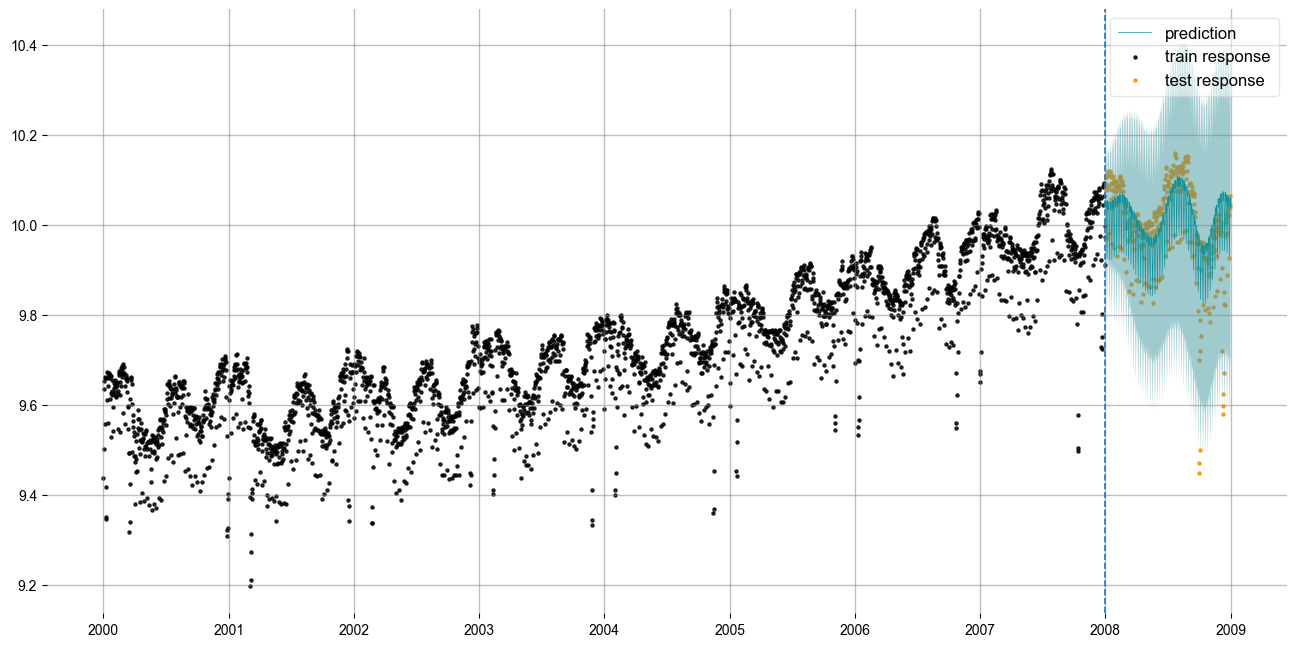

In [41]:
_ = plot_predicted_data(training_actual_df=train_df,
                        predicted_df=predicted_df, 
                        date_col=DATE_COL,
                        actual_col=RESPONSE_COL, 
                        test_actual_df=test_df,
                        markersize=20, lw=.5)

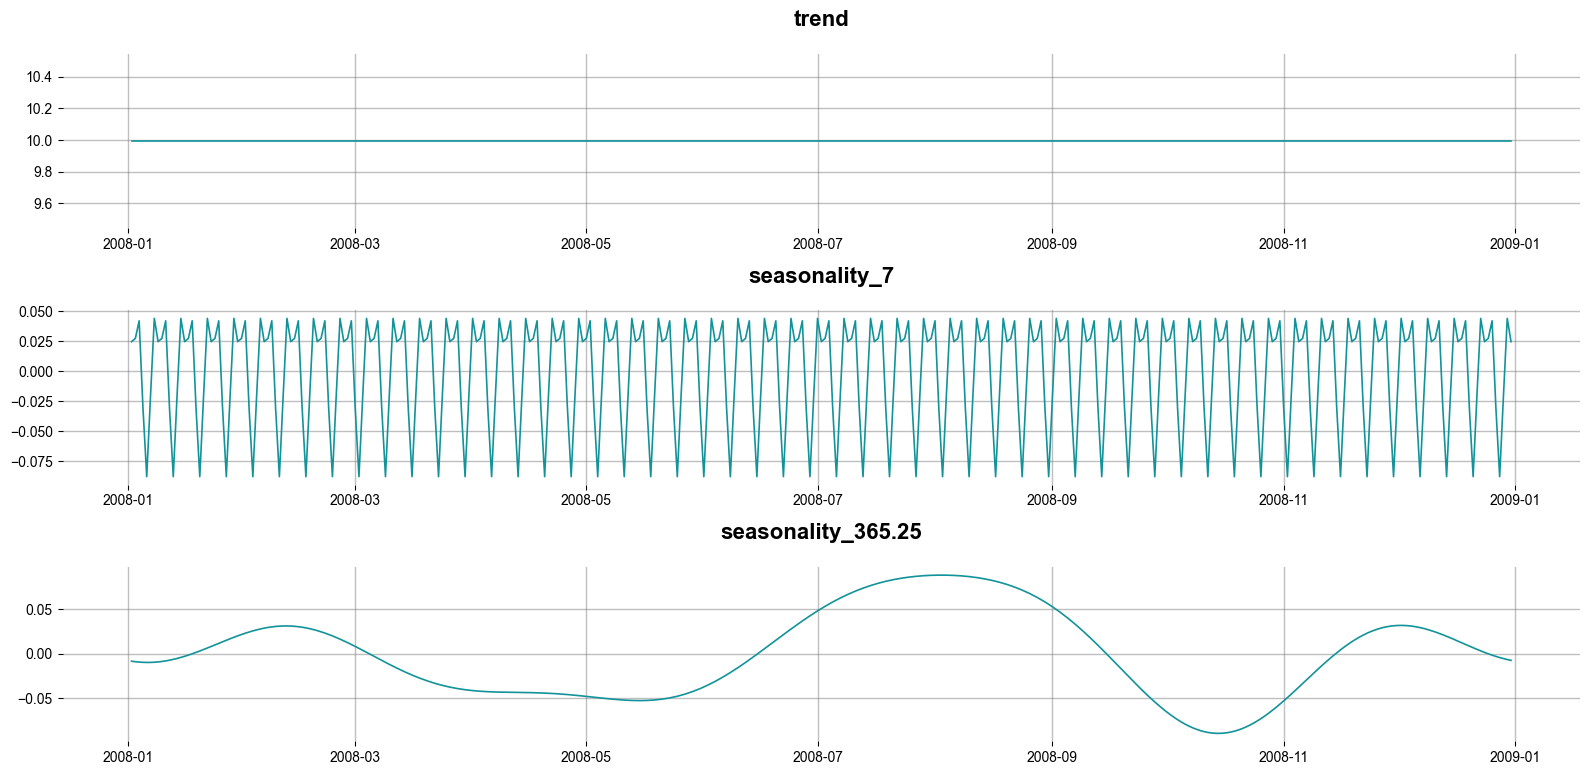

In [14]:
_ = plot_predicted_components(predicted_df=predicted_df,
                              date_col=DATE_COL, 
                              plot_components=['trend', 'seasonality_7', 'seasonality_365.25'])

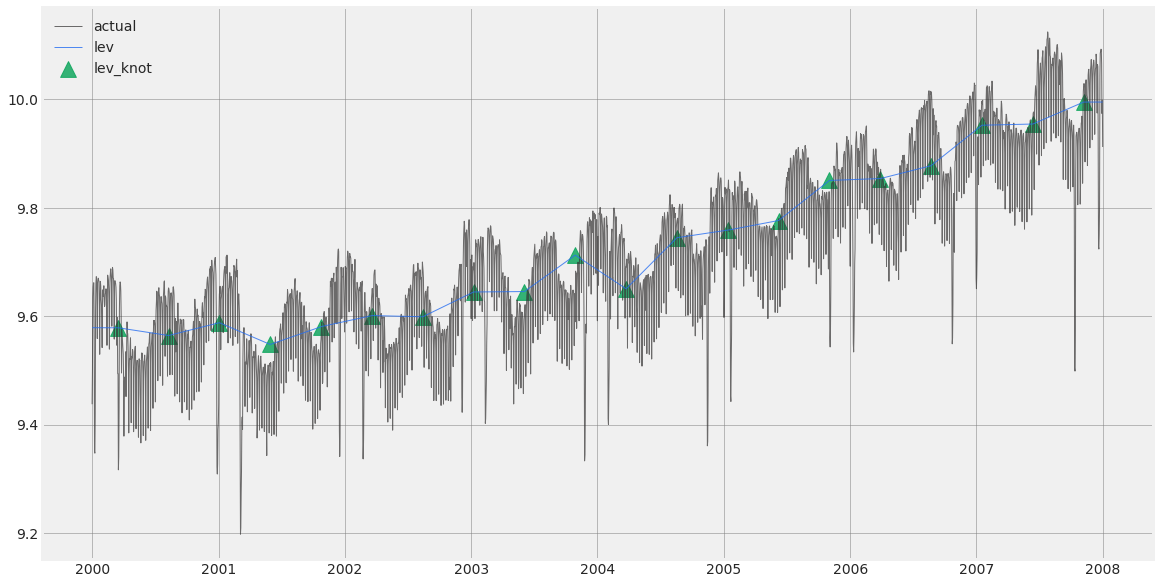

In [13]:
_ = ktrlite.plot_lev_knots()

In [21]:
lev_knots_df = ktrlite.get_level_knots()
lev_knots_df.head()

,date,lev_knot
0,2000-03-15,9.57878
1,2000-08-09,9.56434
2,2001-01-03,9.58799
3,2001-05-30,9.54782
4,2001-10-24,9.58073


# Stability Check

In [43]:
ktrlite1 = KTRLite(                   
    date_col=DATE_COL,
    response_col=RESPONSE_COL,
    seasonality=[7, 365.25],
    seasonality_fs_order=[2, 5],
    level_knot_scale=.1,
    span_level=.05,
    span_coefficients=.5,
    estimator='stan-map',
    seed=2020
)


ktrlite2 = KTRLite(
    date_col=DATE_COL,
    response_col=RESPONSE_COL,
    seasonality=[7, 365.25],
    seasonality_fs_order=[2, 5],
    level_knot_scale=.1,
    span_level=.05,
    span_coefficients=.5,
    estimator='stan-map',
    seed=2021
)

ktrlite1.fit(df)
ktrlite2.fit(df)

Initial log joint probability = -230340
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19       3735.55     0.0462927          6905       0.214      0.9591       30   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39       5201.35     0.0369423       857.242           1           1       54   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       5424.88      0.049014       1377.82           1           1       75   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       5459.56     0.0259267       387.848      0.8958      0.8958       95   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5471.06     0.0112567       213.448           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha   

In [46]:
np.allclose(
    ktrlite1.get_point_posteriors()['lev_knot'],
    ktrlite2.get_point_posteriors()['lev_knot'],
    rtol=1e-3,
)

True